  # 11. Quantum Noise and Error Mitigation

Toshinari Itoko (June 28, 2024)<br>
© IBM Corp. 2024

*Approximate QPU time to run this experiment is 1 m 40 s.*


In [1]:
# !pip install qiskit qiskit_aer qiskit_ibm_runtime
# !pip install jupyter
# !pip install matplotlib pylatexenc

In [2]:
import qiskit
qiskit.__version__

'1.3.0'

In [3]:
import qiskit_aer
qiskit_aer.__version__

'0.15.1'

In [4]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.__version__

'0.29.0'

Throughout this lesson, we will examine noise and how it can be mitigated on quantum computers. We will begin by looking at the effects of noise using a simulator that can simulate noise in a few ways, including using noise profiles from real quantum computers. Then we will move on to real quantum computers, in which noise is inherent. We will look at the effects of error mitigation, including combinations of things like zero-noise extrapolation (ZNE) and gate-twirling.

# Part 1. Noisy simulation using Qiskit Aer

Qiskit Aer is a classical simulator for quantum computing. It can simulate not only ideal execution but also noisy execution of quantum circuits. This notebook demonstrates how to run noisy simulation using Qiskit Aer:

1. Build a noise model
2. Build a noisy sampler (simulator) with the noise model
3. Run a quantum circuit on the noisy sampler

```
noise_model = NoiseModel()
...
noisy_sampler = Sampler(options={"backend_options": {"noise_model": noise_model}})
job = noisy_sampler.run([circuit])
```

## 0. Build a test circuit

We consider toy 1-qubit circuits which just repeat X gates `d` times (`d`=0 ... 100) and measure the `Z` observable.

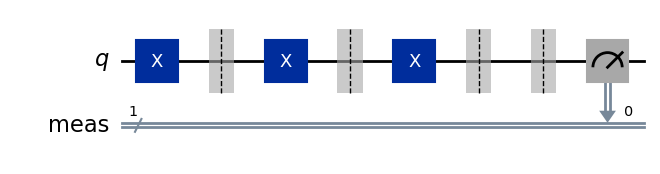

In [5]:
from qiskit.circuit import QuantumCircuit

MAX_DEPTH = 100
circuits = []
for d in range(MAX_DEPTH+1):
    circ = QuantumCircuit(1)
    for _ in range(d):
        circ.x(0)
        circ.barrier(0)
    circ.measure_all()
    circuits.append(circ)

display(circuits[3].draw(output="mpl"))

In [6]:
from qiskit.quantum_info import SparsePauliOp
obs = SparsePauliOp.from_list([("Z", 1.0)])
obs

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

## 1. Build a noise model

To do noisy simulation, we need to specify `NoiseModel`. We show how to build `NoiseModel` in this section.

We first need to define quantum (or readout) errors to add to a noise model.

In [7]:
from qiskit_aer.noise.errors import coherent_unitary_error, amplitude_damping_error, ReadoutError
from qiskit.circuit.library import RXGate

# Coherent (unitary) error: Over X-rotation error
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.coherent_unitary_error.html#qiskit_aer.noise.coherent_unitary_error
OVER_ROTATION_ANGLE = 0.05
coherent_error = coherent_unitary_error(RXGate(OVER_ROTATION_ANGLE).to_matrix())

# Incoherent error: Amplitude dumping error
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.amplitude_damping_error.html#qiskit_aer.noise.amplitude_damping_error
AMPLITUDE_DAMPING_PARAM = 0.02  # in [0, 1] (0: no error)
incoherent_error = amplitude_damping_error(AMPLITUDE_DAMPING_PARAM)

# Readout (measurement) error: Readout error
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.ReadoutError.html#qiskit_aer.noise.ReadoutError
PREP0_MEAS1 = 0.03  # P(1|0): Probability of preparing 0 and measuring 1
PREP1_MEAS0 = 0.08  # P(0|1): Probability of preparing 1 and measuring 0
readout_error = ReadoutError([
    [1 - PREP0_MEAS1, PREP0_MEAS1],
    [PREP1_MEAS0, 1 - PREP1_MEAS0]
])

In [8]:
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel()
noise_model.add_quantum_error(coherent_error.compose(incoherent_error), 'x', (0, ))
noise_model.add_readout_error(readout_error, (0, ))

## 2. Build a noisy sampler with the noise model

In [9]:
from qiskit_aer.primitives import SamplerV2 as Sampler
noisy_sampler = Sampler(options={"backend_options": {"noise_model": noise_model}})

## 3. Run quantum circuits on the noisy sampler


In [10]:
job = noisy_sampler.run(circuits, shots=400)

In [11]:
result = job.result()

In [12]:
result[0].data.meas.get_counts()

{'0': 386, '1': 14}

## Plot results

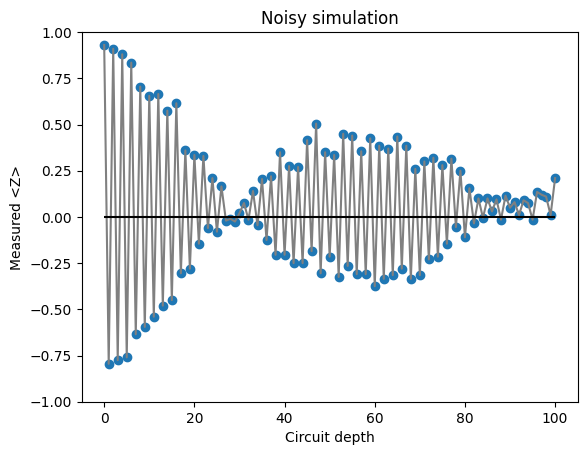

In [13]:
import matplotlib.pyplot as plt
plt.title(f"Noisy simulation")
ds = list(range(MAX_DEPTH+1))
plt.plot(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], color="gray", linestyle="-",)
plt.scatter(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o")
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

## Ideal simulation

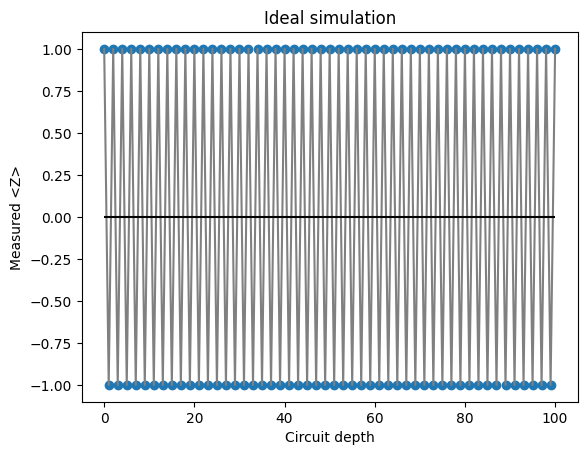

In [14]:
ideal_sampler = Sampler()
job_ideal = ideal_sampler.run(circuits)
result_ideal = job_ideal.result()
plt.title(f"Ideal simulation")
ds = list(range(MAX_DEPTH+1))
plt.plot(ds, [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds], color="gray", linestyle="-",)
plt.scatter(ds, [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o")
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

## Exercise
By tweaking the code below,
- [ ] Try 25x number of shots (= 10_000 shots) and ensure that a smoother plot is obtained
- [ ] Change noise parameters (OVER_ROTATION_ANGLE, AMPLITUDE_DAMPING_PARAM, PREP0_MEAS1, or PREP1_MEAS0) and see how the plot changes

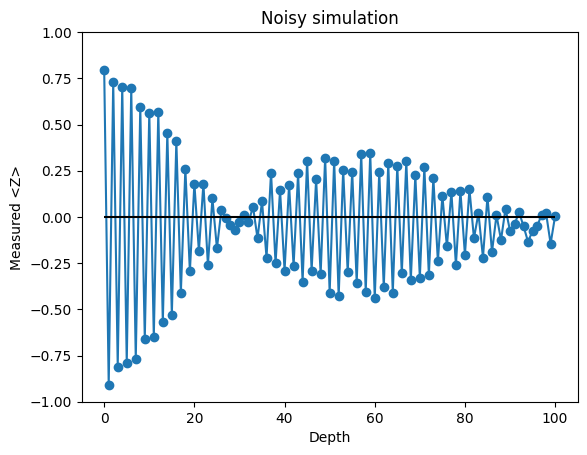

In [16]:
OVER_ROTATION_ANGLE = 0.05
coherent_error = coherent_unitary_error(RXGate(OVER_ROTATION_ANGLE).to_matrix())
AMPLITUDE_DAMPING_PARAM = 0.02  # in [0, 1] (0: no error)
incoherent_error = amplitude_damping_error(AMPLITUDE_DAMPING_PARAM)
PREP0_MEAS1 = 0.1  # P(1|0): Probability of preparing 0 and measuring 1
PREP1_MEAS0 = 0.05  # P(0|1): Probability of preparing 1 and measuring 0
readout_error = ReadoutError([
    [1 - PREP0_MEAS1, PREP0_MEAS1],
    [PREP1_MEAS0, 1 - PREP1_MEAS0]
])
noise_model = NoiseModel()
noise_model.add_quantum_error(coherent_error.compose(incoherent_error), 'x', (0, ))
noise_model.add_readout_error(readout_error, (0, ))
options = {
    "backend_options": {"noise_model": noise_model},
}
noisy_sampler = Sampler(options=options)
job = noisy_sampler.run(circuits, shots=400)
result = job.result()
plt.title(f"Noisy simulation")
ds = list(range(MAX_DEPTH+1))
plt.plot(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o", linestyle="-",)
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Depth")
plt.ylabel("Measured <Z>")
plt.show()

## More realistic noisy simulation

In [16]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
service = QiskitRuntimeService()
real_backend = service.backend('ibm_sherbrooke')

### 1'. Build noise model from a real backend

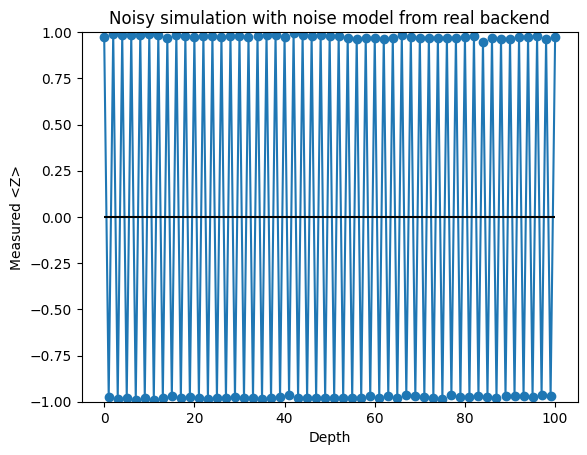

In [17]:
aer = AerSimulator.from_backend(real_backend)
noisy_sampler = Sampler(mode=aer)
job = noisy_sampler.run(circuits)
result = job.result()
plt.title(f"Noisy simulation with noise model from real backend")
ds = list(range(MAX_DEPTH+1))
plt.plot(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o", linestyle="-",)
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Depth")
plt.ylabel("Measured <Z>")
plt.show()

# Part 2. Error Mitigation using Qiskit Primitives

In this part, we demonstrate how to obtain error mitigated results (expectation values) using Qiskit Estimator.
We consider 6-qubit Trotterized circuits for simulating the time evolution of one dimensional Ising model and see how the error scales with respect to the number of time steps.

In [18]:
backend = service.backend('ibm_sherbrooke')

In [19]:
NUM_QUBITS = 6
NUM_TIME_STEPS = list(range(8))
RX_ANGLE = 0.1
RZZ_ANGLE = 0.1

### 1. Build circuits

In [20]:
# Build circuits with different number of time steps
circuits = []
for n_steps in NUM_TIME_STEPS:
    circ = QuantumCircuit(NUM_QUBITS)
    for i in range(n_steps):
        # rx layer
        for q in range(NUM_QUBITS):
            circ.rx(RX_ANGLE, q)
        # 1st rzz layer
        for q in range(1, NUM_QUBITS-1, 2):
            circ.rzz(RZZ_ANGLE, q, q+1)
        # 2nd rzz layer
        for q in range(0, NUM_QUBITS-1, 2):
            circ.rzz(RZZ_ANGLE, q, q+1)
    circ.barrier()  # need not to optimize the circuit
    # Uncompute stage
    for i in range(n_steps):
        for q in range(0, NUM_QUBITS-1, 2):
            circ.rzz(-RZZ_ANGLE, q, q+1)
        for q in range(1, NUM_QUBITS-1, 2):
            circ.rzz(-RZZ_ANGLE, q, q+1)
        for q in range(NUM_QUBITS):
            circ.rx(-RX_ANGLE, q)
    circuits.append(circ)

To know the ideal output in advance, we use compute-uncompute circuits that consist of a first stage where the original circuit $U$ is applied, and a second stage where it is reversed $U^\dagger$.
Note that the ideal outcome of such circuits will trivially be the input state $|000000\rangle$, which has the trivial expectation values for any Pauli observables, e.g. $\langle IIIIIZ \rangle = 1$.

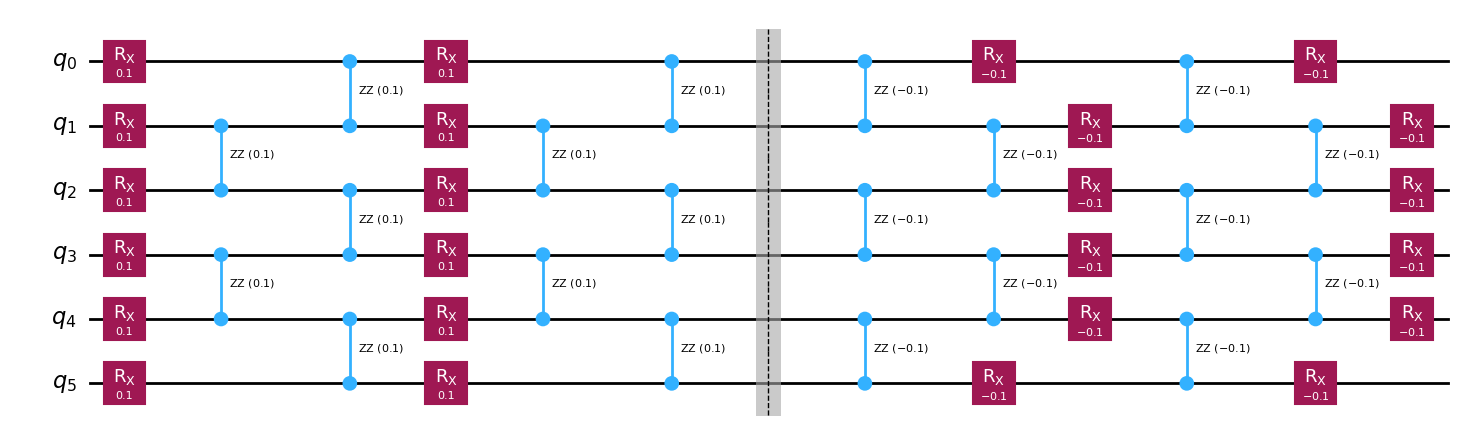

In [21]:
# Print the circuit with 2 time steps
circuits[2].draw(output="mpl")

Note: As shown above, the circuit with $k$ time steps will have $4k$ two-qubit gate layers.

In [22]:
obs = SparsePauliOp.from_sparse_list([("Z", [0], 1.0)], num_qubits=NUM_QUBITS)
obs

SparsePauliOp(['IIIIIZ'],
              coeffs=[1.+0.j])

### 2. Transpile the circuits

We transpile the circuits for the backend with optimization (`optimization_level=1`).

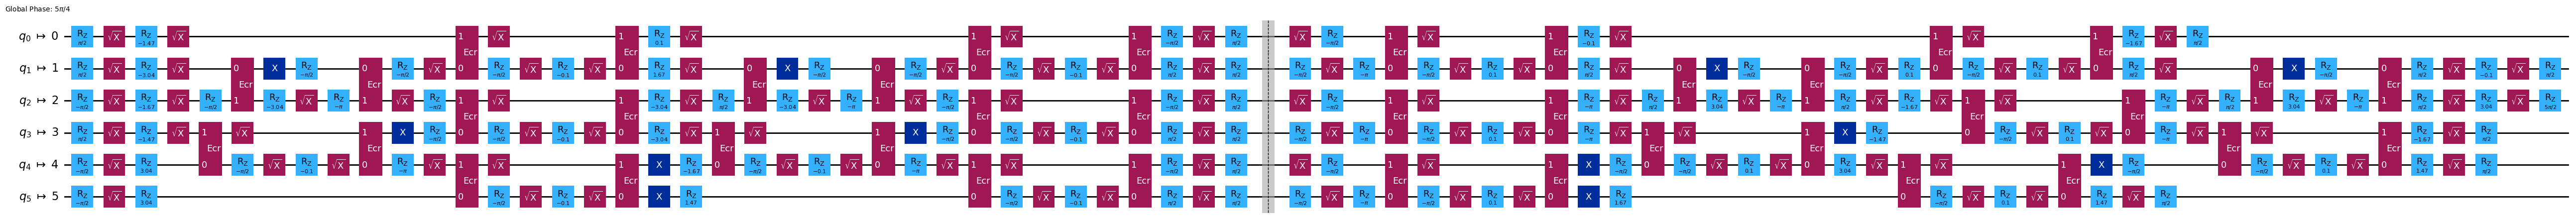

In [23]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuits = pm.run(circuits)
display(isa_circuits[2].draw('mpl', idle_wires=False, fold=-1))

### 3. Execute using Estimator (with different resilience levels)

Setting the resilenece level (`estimator.options.resilience_level`) is the easiest way to apply error mitigation when using Qiskit Estimator. Estimator supports the following resilience levels (as of 2024/06/28). Check https://docs.quantum.ibm.com/guides/configure-error-mitigation for the details.
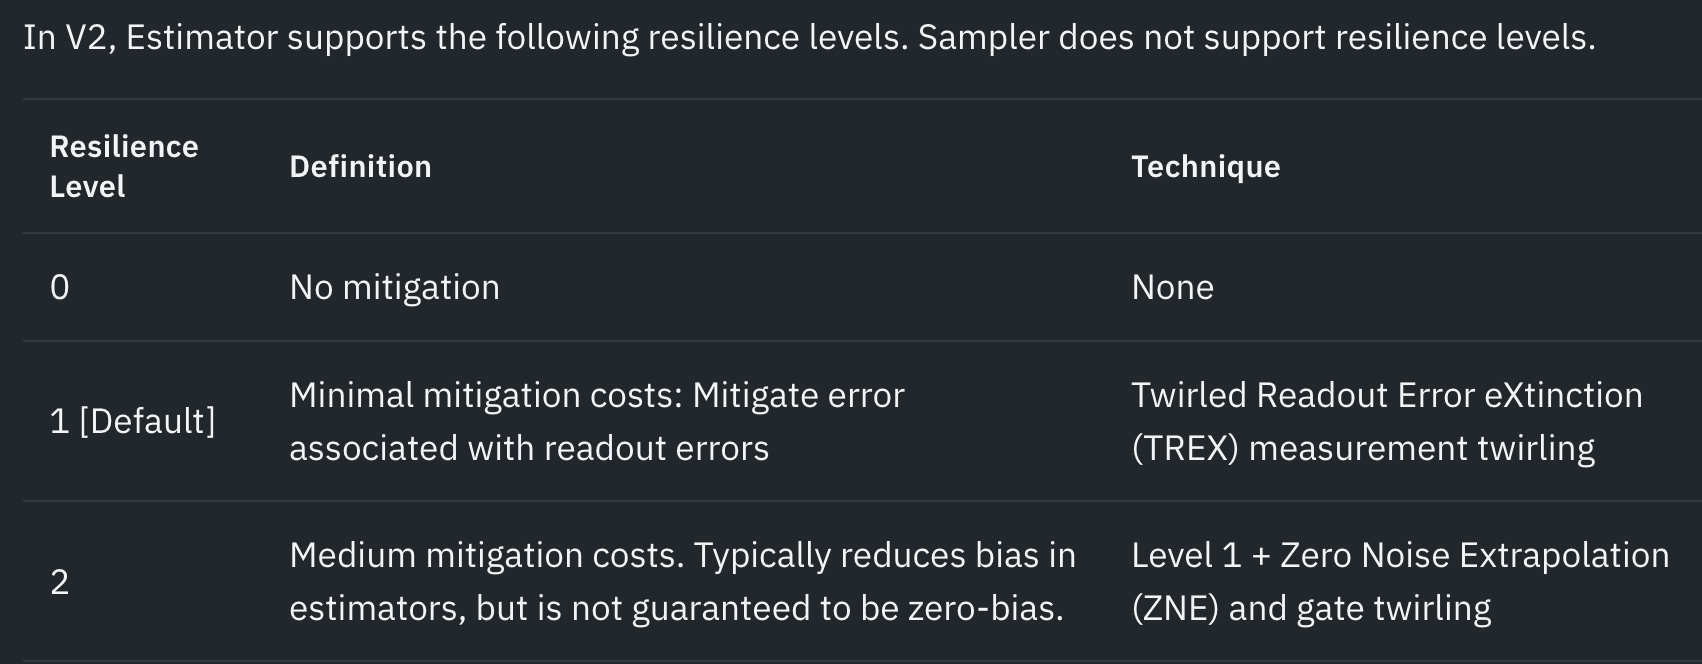

In [24]:
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import EstimatorV2 as Estimator

jobs = []
with Batch(backend=backend):
    for resilience_level in [0, 1, 2]:
        estimator = Estimator()
        estimator.options.resilience_level = resilience_level
        job = estimator.run([(circ, obs.apply_layout(circ.layout)) for circ in isa_circuits])
        print(f"Job ID (rl={resilience_level}): {job.job_id()}")
        jobs.append(job)

Job ID (rl=0): cy3bx5c01rbg008hxtb0
Job ID (rl=1): cy3bx6w6vek0008rf1h0
Job ID (rl=2): cy3bx856vek0008rf1hg


In [25]:
# REPLACE WITH YOUR OWN JOB IDS
job_ids = ["cy3bx5c01rbg008hxtb0", "cy3bx6w6vek0008rf1h0", "cy3bx856vek0008rf1hg"]
jobs = [service.job(job_id) for job_id in job_ids]

In [ ]:
# Get results
results = [job.result() for job in jobs]

### 4. Plot results

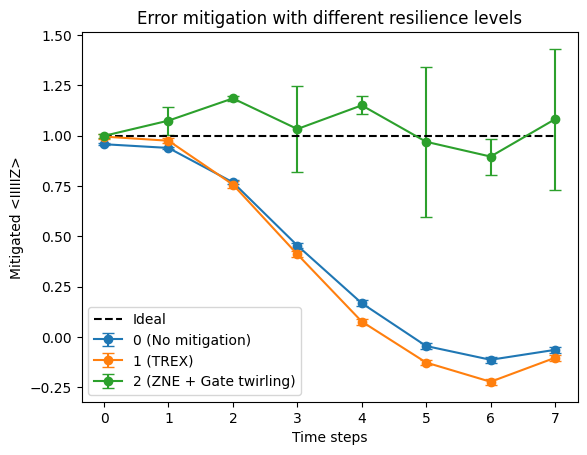

In [28]:
plt.title(f"Error mitigation with different resilience levels")
labels = ["0 (No mitigation)", "1 (TREX)", "2 (ZNE + Gate twirling)"]
steps = NUM_TIME_STEPS
for result, label in zip(results, labels):
    plt.errorbar(
        x=steps,
        y=[result[s].data.evs for s in steps],
        yerr=[result[s].data.stds for s in steps],
        marker="o", linestyle="-", capsize=4, label=label
    )
plt.hlines(1.0, min(steps), max(steps), linestyle="dashed", label="Ideal", colors="black")
plt.xlabel("Time steps")
plt.ylabel("Mitigated <IIIIIZ>")
plt.legend()
plt.show()

## (Optional) Customize error mitigaiton options

We can customize the application of error mitigation techniques via options as shown below.

In [ ]:
# TREX
estimator.options.twirling.enable_measure = True
estimator.options.twirling.num_randomizations = "auto"
estimator.options.twirling.shots_per_randomization = "auto"

# Gate twirling
estimator.options.twirling.enable_gates = True
# ZNE
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = [1, 3, 5]
estimator.options.resilience.zne.extrapolator = ("exponential", "linear")

# Dynamical decoupling
estimator.options.dynamical_decoupling.enable = True  # Default: False
estimator.options.dynamical_decoupling.sequence_type = "XX"

# Other options
estimator.options.default_shots=10_000

See the following documents for the details of error mitigation options.
- Configure error mitigation for Qiskit Runtime: https://docs.quantum.ibm.com/run/configure-error-mitigation
- Advanced Qiskit Runtime options: https://docs.quantum.ibm.com/run/advanced-runtime-options
- EstimatorOptions: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.EstimatorOptions
- SamplerOptions: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.SamplerOptions